# Causal Machine Learning
What follows is a series of exercises by an economics PhD student on a quest to sharpen her econ coding skills - this time: Causal Machine Learning - with a lot of help from ChatGPT.

This notebook contains the following:

1.   Feature Importance in causal ML models
2.   Estimating heterogenous treatment effects (HTE) using the `econml` package.

I have in mind to add the following in future:


*   More HTE estimation
*   Inference


Feel free to reach me at zkhnl@uw.edu and check out more totally amateur tutorials at https://github.com/zahrakhanalizade/econ_coding

## Installing and Dependency Shenanigans

Basically you need to install econml, but econml can be a bit picky about its friends (a.k.a dependencies). So you might have to deal with those before proceeding to the actual work. (You can do it, I believe in you!) Examples of some shenanigans I had to pull for econml to work can be found as comments in the below cell; feel free to ignore them.

In [ ]:
# (Basically these are because the econml package wouldn't run on newer versions of certain packages so I had to downgrade them.)

# pip install --force-reinstall scikit-learn==1.5.0
#!pip install --force-reinstall numpy==1.26.4
# import sklearn
# import econml
# import numpy
# print("scikit-learn version:", sklearn.__version__)
# print("econml version:", econml.__version__)
# print("numpy version:", numpy.__version__)


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


#Feature importance in causal ML models

**Feature importance** is a common concept in machine learning that measures how much each feature contributes to a model’s predictions. In standard models, it reflects how influential a feature is in predicting the outcome.

In the context of **causal inference**, feature importance takes on a slightly different role. For example, in Causal Forests, feature importance measures how much each feature contributes to the estimation of **heterogeneous treatment effects (HTEs)**. This is especially useful for identifying which features drive variations in causal effects across the population.

Think of it as a detective tool for spotting the key players behind treatment effect differences — crucial for understanding **why** some individuals or groups respond better (or worse) to an intervention.

**Why Does This Matter?**
For example, in a marketing study, feature importance can reveal which user characteristics — like age, location, or purchase history — most influence how a treatment (e.g., a coupon) impacts purchasing behavior.

⚠️ **Careful** when interpreting the results of feature importance:

**Higher feature importance ≠ Higher effect size**

Feature importance only tells you which features help predict variation in treatment effects — not necessarily which features have **large causal effects** themselves.

In other words, a feature might be important because it’s a strong predictor of **where** the effect varies, not because it directly drives the treatment effect.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML

# Simulated data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 5))  # Features
T = np.random.binomial(1, 0.5, size=n)   # Treatment assignment
y = 1 + 2 * T + np.dot(X, [0.5, -0.2, 0.1, 0, 0]) + np.random.normal(0, 1, size=n)  # Outcome

# Train/test split
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

# Define the causal forest
causal_forest = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# Fit the model
causal_forest.fit(y_train, T_train, X=X_train)

# Compute feature importance
feature_importances = causal_forest.feature_importances_

# Display feature importance
for i, importance in enumerate(feature_importances):
    print(f"Feature {i + 1}: Importance = {importance:.4f}")


First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


Feature 1: Importance = 0.2551
Feature 2: Importance = 0.2239
Feature 3: Importance = 0.1316
Feature 4: Importance = 0.1889
Feature 5: Importance = 0.2005


## Interpretation of Feature Importance Results

The feature importance results suggest that all five features contribute meaningfully to the estimated treatment effects, though some play a larger role than others.

Feature 1 (Importance = 0.2551) → The most influential feature. This feature drives the most variation in treatment effects across individuals.

**Key Takeaways**

✅ No single feature dominates. The relatively balanced importances suggest that multiple features jointly influence the treatment effect — a sign that the data has meaningful complexity.

✅ Feature 1 stands out slightly. It’s worth exploring this feature to understand why it’s driving treatment heterogeneity.

# Estimating Conditional Average Treatment Effects (CATE)

Now let's get down to business — it's time to estimate some Conditional Average Treatment Effects (CATE) as we casually ease our way into the broader topic of heterogeneous treatment effects.

Below I'll first give a quick rundown of the handy dandy OHDP dataset we'll be using and then we'll define the DML model.

# Data Context:

## The IHDP (Infant Health and Development Program) Dataset

The IHDP dataset is a well-known benchmark for causal inference tasks. It simulates a real-world setting where treatment effects vary based on observed covariates.

## About the IHDP Dataset
**Context:** The dataset comes from a real clinical trial studying the effects of home visits on cognitive test scores for infants with low birth weight.

**Outcome (Y):** Cognitive score at age 3.

**Treatment (T):** Whether the child received the home visit intervention (binary).

**Covariates (X):** Child and mother demographics such as birth weight, mother’s education, and more.

**True Treatment Effect (τ):** The true effect is known, making this dataset ideal for testing causal models.

In [ ]:
# Load the IHDP dataset
url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
data = pd.read_csv(url)

## DML

In [ ]:
import numpy as np
import pandas as pd
from econml.dml import DML
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
col = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"]
for i in range(1, 26):
    col.append(f"x{i}")
data.columns = col
data = data.astype({"treatment": 'bool'}, copy=False)

# Extract features, treatment, and outcome
X = data.drop(['treatment', 'y_factual'], axis=1).values
T = data['treatment'].values
Y = data['y_factual'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)




### Define a DML estimator

I went with **Lasso** for the *outcome model* and **Random Forest** for the *treatment model*.

(You can get creative here. The world of ML models is your oyster!)

The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


Mean Squared Error of CATE Estimates: 27.9339
First 5 CATE estimates: [ 5.19716124  4.38173155  3.9325128   0.90468077 -2.08897157]


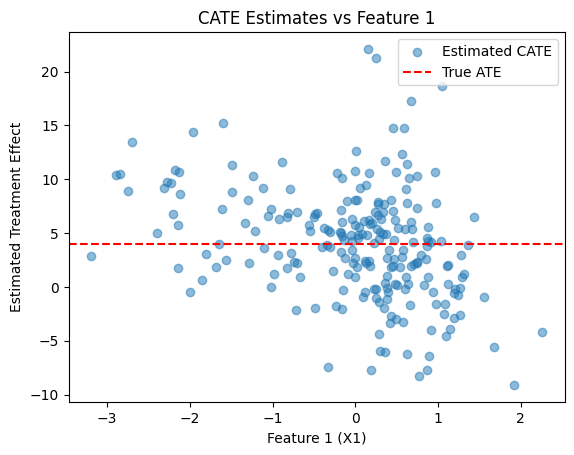

In [ ]:
# DML Estimator with Lasso for outcome model and RF for treatment model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

dml = DML(
    model_y=LassoCV(),                    # Outcome model
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10),      # Treatment model
    model_final=LinearRegression(),                # Final-stage model for effect estimation
    cv=3                                  # Cross-validation folds
)


dml.fit(Y_train, T_train, X=X_train)

# Predict CATE
cate = dml.effect(X_test)

# Evaluate Performance
true_effect = data['mu1'].values - data['mu0'].values  # True treatment effect
true_effect_test = true_effect[-len(X_test):]  # True ATE for the test set

# Compute Mean Squared Error for model quality
mse = mean_squared_error(true_effect_test, cate)
print(f"Mean Squared Error of CATE Estimates: {mse:.4f}")

# Interpretation
print("First 5 CATE estimates:", cate[:5])

# Visualizing results
plt.scatter(X_test[:, 0], cate, alpha=0.5, label='Estimated CATE')
plt.axhline(y=np.mean(true_effect), color='red', linestyle='--', label='True ATE')
plt.xlabel("Feature 1 (X1)")
plt.ylabel("Estimated Treatment Effect")
plt.legend()
plt.title("CATE Estimates vs Feature 1")
plt.show()


## CATEs should make sense
Like I said, the world of ML models is your oyster - so go ahead, mix and match models for the outcome and treatment steps.

⚠️ **But be warned:** Just because you can get creative doesn’t mean you should go wild without caution.


*   Make sure your models don’t overfit or underfit.

*   And remember, **CATEs should make sense**: They should roughly average to the ATE.

For example, check out the next graph — the CATEs are consistently below the true effect, and no amount of mental gymnastics can make these average to the ATE.

What went wrong? Well, in this case, I swapped out LinearRegression for LassoCV as the final-stage model, and apparently, LassoCV decided to show off and overfit. (Lesson learned: Visual sanity checks save the day!)


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


Mean Squared Error of CATE Estimates: 3.8861
First 5 CATE estimates: [1.73116722 2.59921796 2.33063298 1.840035   2.73413341]


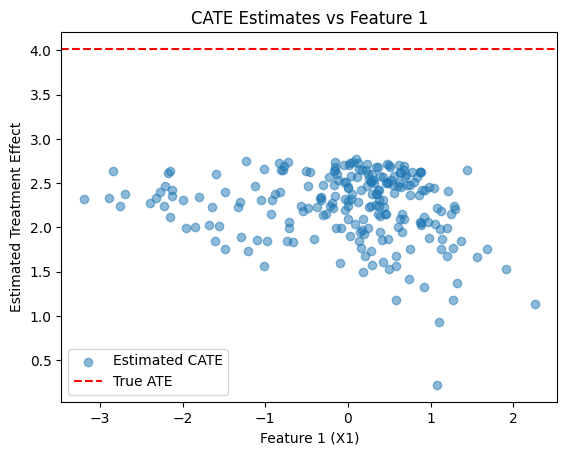

In [ ]:
dml = DML(
    model_y=LassoCV(),                    # Outcome model
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10),      # Treatment model
    model_final=LassoCV(),                # Final-stage model for effect estimation
    cv=3                                  # Cross-validation folds
)


dml.fit(Y_train, T_train, X=X_train)

# Predict CATE
cate = dml.effect(X_test)

# Evaluate Performance
true_effect = data['mu1'].values - data['mu0'].values  # True treatment effect
true_effect_test = true_effect[-len(X_test):]  # True ATE for the test set

# Compute Mean Squared Error for model quality
mse = mean_squared_error(true_effect_test, cate)
print(f"Mean Squared Error of CATE Estimates: {mse:.4f}")

# Interpretation
print("First 5 CATE estimates:", cate[:5])

# Visualizing results
plt.scatter(X_test[:, 0], cate, alpha=0.5, label='Estimated CATE')
plt.axhline(y=np.mean(true_effect), color='red', linestyle='--', label='True ATE')
plt.xlabel("Feature 1 (X1)")
plt.ylabel("Estimated Treatment Effect")
plt.legend()
plt.title("CATE Estimates vs Feature 1")
plt.show()


# Next things coming:



*   More HTE estimation
*   Inference

<- Last updated: 3-14-2025